# Convert your judge into a generation prompt

Given
- a certified judge classifier `JUDGE_CLASSIFICATION_PROMPT: str`
- some input string data samples `INPUT_CONTENTS: tuple[str]`
- initial prompt `INITIAL_GENERATION_PROMPT: str`

Produce
- a prompt with a good winrate (measured by the judge) against other prompts

## Foreword

If you can't verify what is good or what is bad, you can't make good generations.

But if you can verify, you should easily be able to make good generations - and this tool helps you write this prompt.


#### Inspirations

- Cohere prompt tuner https://cohere.com/blog/intro-prompt-tuner
- Anthropic workbench https://console.anthropic.com/workbench/
- Chatbot Arena leaderboard https://lmarena.ai/

## Example use case presented in this notebook

Given a Quora answer, write followup questions to the answer.

Great followup questions should be appealing to respond to and answers should be appealing to read.

The inputs for this use case
- `JUDGE_CLASSIFICATION_PROMPT: str` - prompt that classifies whether one set of prompts is better than the other
- `INPUT_CONTENTS: tuple[str]` - Quora answers
- `INITIAL_GENERATION_PROMPT: str` - prompt that generates followup questions

Produce
- a prompt with a good winrate (measured by the judge) against other prompts

## Frequently asked questions

Why don't you include `JUDGE_CLASSIFICATION_PROMPT` in the generation prompt?
- You can if you want. But the result still needs to perform better according to the judge.
- I expect models in the future to be brainstorming responses and then think carefully which is the response is the best. However, doing so will incur extra cost and latency, and we might not want this tradeoff.
- The idea of prompt engineering for the generation prompt is to teach the model shortcuts on what good outputs are.

Why don't you tune the `JUDGE_CLASSIFICATION_PROMPT` as well?
- In this tool we assume that we trust `JUDGE_CLASSIFICATION_PROMPT`.
- It is important to get this right. You should tune this, and tune this elsewhere.
- In practice we do want to provide feedback to point out where the judge is obviously wrong. I leave this to the roadmap.

Why is the `JUDGE_CLASSIFICATION_PROMPT` doing comparison of two generation outputs instead of classifying whether one is good?
- For some answers it is easy to generate good followup questions but tricky to generate great followup questions.
- In other answers it may be even difficult to generate followup questions that are not outright bad.
- I want the judge to be useful in both cases.

# TODO

- Print intermediate results to html
- Improve the optimization prompt
- Make the optimization prompt write all of system prompt, user prompt and assistant prefill

In [1]:
from functools import cache

import anthropic
client = anthropic.Anthropic()

# Inputs for the tool user

In [2]:
import pandas as pd
df = pd.read_csv("content.csv").head(5)

In [3]:
df.head(2)

,content
0,Why do AI image generators have so much troubl...
1,At what point do you consider an LLM to have a...


In [4]:
INPUT_CONTENTS: tuple[str] = tuple(df["content"])

In [5]:
INITIAL_GENERATION_PROMPT = """
You are given the following source question and a source answer.

<source_question_and_answer>
{input_content}
</source_question_and_answer>

Write 5 followup questions to the answer.

Reply in this format 

<questions>

<question>
question
<question>

...

</questions>
""".strip()

In [6]:
JUDGE_CLASSIFICATION_PROMPT = """
You are given an answer and two sets of followup questions.

Determine which set of followup questions is better.

These are required
- Each question should appear between <question> and </question>
- There should be 5 questions

The followup questions are considered bad if they have any of these characteristics
- There ambiguous references in the question that cannot be understood without context
- The question is using extra words than necessary

If both set of questions have neither of the bad characteristics, the better set of followup questions should have these characteristics
- Each question should be distinct
- The questions ask for knowledge that is not easily found online
- The author is likely to answer the questions
- People interested in the source question and answer will also be interested in answers to the followup questions

This is the source question and source answer
<source_question_and_answer>
{input_content}
</source_question_and_answer>

This is the first set of followup questions

{response_one}

This is the second set of followup questions

{response_two}

Write some reasoning, end your response with one for the following
- Set <label>one</label> is better.
- Set <label>two</label> is better.
- Both sets <label>tie</label>.
""".strip()

# Judge classification prompt

In [7]:
# We assume that we trust this prompt
judge_classification_prompt = JUDGE_CLASSIFICATION_PROMPT

def judge_classification(
    input_content: str,
    response_one: str,
    response_two: str,
) -> tuple[str, str]:
    # return either one, two or tie
    
    message = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1024,
        messages=[
            {
                "role": "user", 
                "content": judge_classification_prompt.format(
                    input_content=input_content,
                    response_one=response_one,
                    response_two=response_two,
                )
            },
        ],
    )
    message_text = message.content[0].text
    if "<label>one</label>" in message_text:
        return message_text, "one"
    if "<label>two</label>" in message_text:
        return message_text, "two"
    return message_text, "tie"

In [8]:
input_content = """
Why do AI image generators have so much trouble rendering hands?

Tong Hui Kang
Machine Learning Engineer in Recommendations
The current AI image generators are not rewarded for drawing hands well.
The training input for image models is a huge set of images and their captions. The objective here is to fit a function f(caption) -> image, by minimizing some loss function L(caption, image).
L(caption, image) is high when the image is unrelated to the caption, and L(caption, image) is low when the image is very related to the caption. The image generation model is trained to minimize L(caption, image).
However, L(caption, image) might be high for images with deformities, because L(caption, image) might only measure whether the image is related to the caption.
If you don’t penalize deformities in the training, you can’t generate images free-of-deformities. As of my current understanding, generating images without deformities is still an open question.
""".strip()

response_one = """
<question>What are some AI image generation models?</question>

<question>Where can I find the training set for the image models?</question>

<question>What are some ways to improve the quality of AI-generated images?</question>

<question>What is the role of captions in AI image generation?</question>

<question>What techniques have researchers tried so far to address the hand rendering problem?</question>
"""

response_two = """
<question>How do we reward AI image generators to draw hands correction?</question>

<question>Why are hands particularly challenging compared to other anatomical features?</question>

<question>What preprocessing techniques have worked best for curating training datasets that lead to better hand renderings?</question>

<question>What specific loss functions have you found most effective for detecting and penalizing anatomical deformities in AI-generated images?</question>

<question>How do different AI image generation models (like Stable Diffusion, DALL-E, Midjourney) compare in their ability to render hands?</question>
"""

In [9]:
justification, judgement = judge_classification(
    input_content=input_content,
    response_one=response_one,
    response_two=response_two,
)

In [10]:
judgement

'two'

In [11]:
print(justification)

Let me analyze both sets:

Set 1:
- Questions are clear and concise
- Questions are quite generic and answers can be easily found online
- Most questions don't directly build on the specific topic of hand rendering issues
- Questions feel disconnected from the technical depth of the original answer

Set 2:
- Questions are specifically focused on the hand rendering problem
- Questions build naturally from the technical explanation given in the answer
- Questions delve deeper into the specific challenges and solutions
- Questions ask for experiential knowledge that would be valuable to others interested in this topic
- Questions address practical aspects of implementation and comparison

Looking at the specific problems mentioned:
- Neither set has ambiguous references
- Neither set uses unnecessary words
- Set 2 has more distinct questions while Set 1 has some overlap
- Set 2 asks for knowledge that would be harder to find through simple online searches
- Set 2's questions are more like

In [12]:
justification, judgement = judge_classification(
    input_content=input_content,
    response_one=response_two,  # swapped
    response_two=response_one,  # swapped
)

In [13]:
judgement

'one'

In [14]:
print(justification)

Let me analyze both sets:

Set 1:
- Questions are specific and focused on the hand rendering problem
- All questions naturally follow from the source answer
- Questions seek expert knowledge that isn't easily Googled
- The questions are distinct from each other
- Someone interested in AI image generation would be very interested in these answers
- No ambiguous references
- Questions are concise

Set 2:
- Questions are more general about AI image generation
- Some questions are too basic and can be easily searched online (e.g., "What are some AI image generation models?")
- Questions are less focused on the specific problem of hand rendering
- The questions are distinct but several seem to diverge from the main topic
- Questions are concise
- No ambiguous references

Reasoning:
1. Set 1 maintains focus on the specific problem of hand rendering while Set 2 drifts into general AI image generation topics
2. Set 1's questions require expert knowledge and experience, while Set 2's questions 

# Generation prompt

In [15]:
def generation(
    generation_prompt: str,
    input_content: str,
) -> str:
    try:
        generation_prompt_with_inputs = generation_prompt.format(
            input_content=input_content,
        )
    except:
        return "{input_content} should appear in the prompt"

    message = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1024,
        messages=[
            {
                "role": "user", 
                "content": generation_prompt_with_inputs
            },
        ],
        stop_sequences=["</questions>"],
    )
    message_text = message.content[0].text
    return message_text

In [16]:
response = generation(INITIAL_GENERATION_PROMPT, input_content)

In [17]:
print(response)

<questions>

<question>
What specific loss functions are commonly used in AI image generation models to measure the relationship between captions and images?
</question>

<question>
How could the loss function be modified to explicitly penalize anatomical deformities like incorrect hand rendering?
</question>

<question>
Are there any current research efforts or proposed solutions to address the problem of deformities in AI-generated images?
</question>

<question>
Do other complex anatomical features (like faces or feet) face similar rendering challenges, or is this issue unique to hands?
</question>

<question>
Could using specialized training datasets focused on hands and hand movements help improve the accuracy of hand rendering in AI image generators?
</question>




# Win rate calculation

In [18]:
import concurrent.futures

@cache
def calculate_winrate(
    input_contents: tuple[str],
    generation_prompt_one: str,
    generation_prompt_two: str,
):
    one_win = 0 
    two_win = 0

    one_wins_judgements = []
    one_loses_judgements = []
    two_wins_judgements = []
    two_loses_judgements = []
    one_tie_judgements = []
    two_tie_judgements = []
    
    def calculate_winrate_single(input_content, index):
        response_one = generation(
            generation_prompt=generation_prompt_one,
            input_content=input_content,
        )
        response_two = generation(
            generation_prompt=generation_prompt_two,
            input_content=input_content,
        )
        flipped = (index%2 == 1)
        if not flipped:
            justification, judgement = judge_classification(
                input_content=input_content,
                response_one=response_one,
                response_two=response_two,
            )
        else:
            justification, judgement = judge_classification(
                input_content=input_content,
                response_one=response_two,
                response_two=response_one,
            )
        return justification, judgement, flipped
        
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        results = executor.map(calculate_winrate_single, input_contents, list(range(len(input_contents))))
        results = list(results)    
    
    for justification, judgement, flipped in results:
        if not flipped:
            if judgement == "one":
                one_win += 1
                one_wins_judgements.append(justification)
                two_loses_judgements.append(justification)
            elif judgement == "two":
                two_win += 1
                two_wins_judgements.append(justification)
                one_loses_judgements.append(justification)
            else:
                one_win += 1/2
                two_win += 1/2
                one_tie_judgements.append(justification)
                two_tie_judgements.append(justification)
        else:
            if judgement == "two":
                one_win += 1
                one_wins_judgements.append(justification)
                two_loses_judgements.append(justification)
            elif judgement == "one":
                two_win += 1
                two_wins_judgements.append(justification)
                one_loses_judgements.append(justification)
            else:
                one_win += 1/2
                two_win += 1/2
                one_tie_judgements.append(justification)
                two_tie_judgements.append(justification)
    return (
        (
            one_win / (one_win + two_win),
            one_wins_judgements,
            one_tie_judgements,
            one_loses_judgements,
        ),
        (
            two_win / (one_win + two_win),
            two_wins_judgements,
            two_tie_judgements,
            two_loses_judgements,
        ),
    )

In [19]:
evaluation_one, evaluation_two = calculate_winrate(
    input_contents = INPUT_CONTENTS,
    generation_prompt_one = INITIAL_GENERATION_PROMPT,
    generation_prompt_two = INITIAL_GENERATION_PROMPT,
)

In [20]:
print(str(evaluation_one)[:500])

(0.6, ["Let me analyze both sets:\n\nFirst Set:\n- Questions are clear and focused\n- No ambiguous references\n- Questions follow logically from the source answer\n- Questions are technically specific\n- Questions address different aspects (training, challenges, loss function, research, datasets)\n\nSecond Set:\n- Questions are also clear and focused\n- No ambiguous references\n- Some questions overlap with each other (questions about datasets appear twice)\n- Questions are slightly more repetit


# Prompt optimization

In [21]:
evaluation_string_template = """
Winrate: {winrate}
Cases where the prompt won: {win_judgements}
Cases where the prompt ties: {tie_judgements}
Cases where the prompt loses: {lose_judgements}
"""

In [22]:
optimization_prompt_template = """
Improve the generation prompt according to the feedback

<current_generation_prompt>
{generation_prompt}
</current_generation_prompt>

<feedback>
{evaluation_string}
</feedback>

This is the judging criteria
<judging_criteria>
{judging_criteria}
</judging_criteria>

Summarize the changes that you intend to make, and return the new prompt between <prompt> and </prompt>.
""".strip()

In [23]:
def optimization(
    generation_prompt: str,
    evaluations: list, 
) -> str:
    evaluation_string = ""
    for evaluation in evaluations:
        winrate, win_judgements, tie_judgements, lose_judgements = evaluation
        evaluation_string_single = evaluation_string_template.format(
            winrate=winrate,
            win_judgements=win_judgements,
            tie_judgements=tie_judgements,
            lose_judgements=lose_judgements,
        )
        evaluation_string += evaluation_string_single

    optimization_prompt = optimization_prompt_template.format(
        generation_prompt=generation_prompt,
        evaluation_string=evaluation_string,
        judging_criteria=JUDGE_CLASSIFICATION_PROMPT,
    )

    message = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1024,
        messages=[
            {
                "role": "user", 
                "content": optimization_prompt
            },
        ]
    )
    
    optimization_response = message.content[0].text
    optimized_prompt = extract_from_tags(optimization_response, tag_string="prompt")
    
    return optimization_response, optimized_prompt

In [24]:
import re
def extract_from_tags(text, tag_string="prompt"):
    pattern = f'<{tag_string}>(.*?)</{tag_string}>'
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return ''

In [25]:
optimization_response, optimized_prompt = optimization(INITIAL_GENERATION_PROMPT, [evaluation_one])

In [26]:
print(optimization_response[:1000])

Based on the feedback, I'll make the following improvements to the generation prompt:

1. Add specific guidance about avoiding ambiguous references
2. Emphasize the need for concise questions without unnecessary words
3. Add criteria for good questions:
   - Questions should be distinct from each other
   - Questions should ask for knowledge not easily found online
   - Questions should be within the author's likely expertise
   - Questions should maintain relevance to the original topic
4. Add structure to guide progression from basic to more complex aspects
5. Encourage a mix of theoretical and practical questions when applicable

Here's the improved prompt:

<prompt>
You are given the following source question and a source answer.

<source_question_and_answer>
{input_content}
</source_question_and_answer>

Write 5 followup questions to the answer. Your questions should:
- Be distinct from each other without overlap
- Ask for knowledge that isn't easily found through online searches


In [27]:
print(optimized_prompt)

You are given the following source question and a source answer.

<source_question_and_answer>
{input_content}
</source_question_and_answer>

Write 5 followup questions to the answer. Your questions should:
- Be distinct from each other without overlap
- Ask for knowledge that isn't easily found through online searches
- Be within the author's likely expertise based on their answer
- Be relevant and interesting to people who care about the original question
- Progress naturally from basic to more complex aspects
- Include both theoretical and practical aspects when applicable
- Avoid any ambiguous references that require additional context
- Be concise without unnecessary words

Reply in this format:

<questions>

<question>
question
</question>

...

</questions>


# Iterative optimization

In [28]:
generation_prompts = [INITIAL_GENERATION_PROMPT, INITIAL_GENERATION_PROMPT]

In [29]:
import random
for _ in range(3):
    generation_prompt_latest = generation_prompts[-1]
    evaluations = []
    for generation_prompt_old in generation_prompts[:-1]:
        input_contents = tuple(random.sample(INPUT_CONTENTS, min(20, len(INPUT_CONTENTS))))
        _, evaluation = calculate_winrate(
            input_contents,
            generation_prompt_old,
            generation_prompt_latest,
        )
        evaluations.append(evaluation)

    optimization_response, generation_prompt_new = optimization(generation_prompt_latest, evaluations)
    generation_prompts.append(generation_prompt_new)
    print(generation_prompt_new)
    print("---")

You are given the following source question and a source answer.

<source_question_and_answer>
{input_content}
</source_question_and_answer>

Write 5 followup questions to the answer. Follow these guidelines:

1. Questions must be clear and specific without requiring context to understand
2. Use concise language without unnecessary words
3. Each question should be distinct from the others
4. Focus on insights and knowledge that would be hard to find through a simple web search
5. Questions should be within the author's expertise and experience based on their answer
6. Questions should interest people who came looking for the original question's answer

Reply in this format:

<questions>

<question>
question
</question>

...

</questions>
---
You are given the following source question and a source answer.

<source_question_and_answer>
{input_content}
</source_question_and_answer>

Write 5 followup questions to the answer. Follow these guidelines:

1. Questions must be clear and specifi

# Display winrate table

In [30]:
import numpy as np
win_rate_matrix = [[np.nan for _ in generation_prompts] for _ in generation_prompts]

input_contents = tuple(random.sample(INPUT_CONTENTS, min(20, len(INPUT_CONTENTS))))
for one_idx, prompt_one in enumerate(generation_prompts):
    for two_idx, prompt_two in enumerate(generation_prompts[one_idx+1:], start=one_idx+1):
        evaluation_one, evaluation_two = calculate_winrate(
            input_contents,
            prompt_one,
            prompt_two,
        )
        win_rate_one, _, _, _ = evaluation_one
        win_rate_two, _, _, _ = evaluation_two
        win_rate_matrix[one_idx][two_idx] = win_rate_one
        win_rate_matrix[two_idx][one_idx] = win_rate_two

In [31]:
win_rate_matrix

[[nan, 0.0, 0.2, 0.6, 0.4],
 [1.0, nan, 0.2, 0.6, 0.4],
 [0.8, 0.8, nan, 0.6, 0.0],
 [0.4, 0.4, 0.4, nan, 0.6],
 [0.6, 0.6, 1.0, 0.4, nan]]

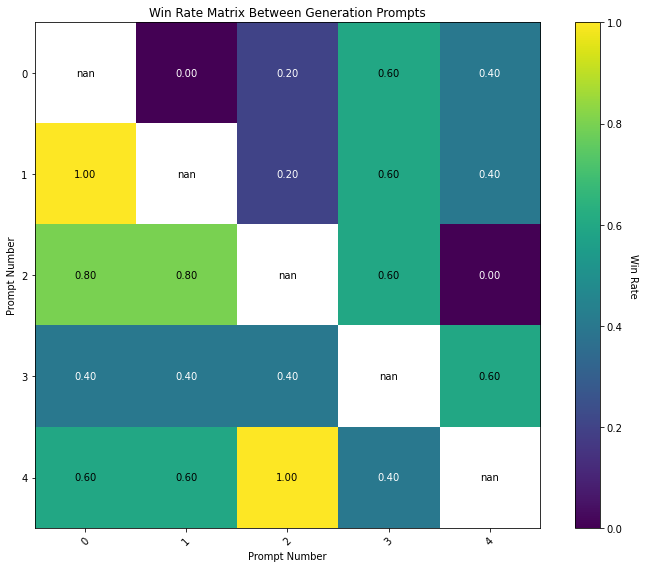

In [32]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Convert the win_rate_matrix to a NumPy array for easier handling
matrix = np.array(win_rate_matrix)

# Determine the number of prompts
num_prompts = len(generation_prompts)

# Create a figure and axis for the heatmap
plt.figure(figsize=(10, 8))
im = plt.imshow(matrix, cmap='viridis')
im.set_clim(0, 1)

# Add a colorbar to show the scale
cbar = plt.colorbar(im)
cbar.set_label('Win Rate', rotation=270, labelpad=15)

# Set the ticks and labels for x and y axes
prompt_indices = range(num_prompts)
plt.xticks(ticks=np.arange(num_prompts), labels=prompt_indices)
plt.yticks(ticks=np.arange(num_prompts), labels=prompt_indices)

# Label the axes
plt.xlabel('Prompt Number')
plt.ylabel('Prompt Number')
plt.title('Win Rate Matrix Between Generation Prompts')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Annotate each cell with the win rate value
for i in range(num_prompts):
    for j in range(num_prompts):
        text = f"{matrix[i, j]:.2f}"
        plt.text(j, i, text, ha='center', va='center',
                 color='white' if matrix[i, j] < 0.5 else 'black')

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

# Conclusion
You notice that the prompts keeps getting better, the each prompt is better than the previous prompt, according the the judge we assume we trust.

In [33]:
print(input_content)

Why do AI image generators have so much trouble rendering hands?

Tong Hui Kang
Machine Learning Engineer in Recommendations
The current AI image generators are not rewarded for drawing hands well.
The training input for image models is a huge set of images and their captions. The objective here is to fit a function f(caption) -> image, by minimizing some loss function L(caption, image).
L(caption, image) is high when the image is unrelated to the caption, and L(caption, image) is low when the image is very related to the caption. The image generation model is trained to minimize L(caption, image).
However, L(caption, image) might be high for images with deformities, because L(caption, image) might only measure whether the image is related to the caption.
If you don’t penalize deformities in the training, you can’t generate images free-of-deformities. As of my current understanding, generating images without deformities is still an open question.


In [34]:
response = generation(generation_prompts[0], input_content)

In [35]:
print(response)

<questions>

<question>
How could AI image generators be modified to specifically penalize hand deformities during training?
</question>

<question>
Are there specific loss functions being developed that can better detect and penalize anatomical irregularities in generated images?
</question>

<question>
Why are hands particularly challenging compared to other body parts in AI image generation?
</question>

<question>
Could using a specialized dataset focused on hand images and poses improve the generation of hands?
</question>

<question>
Is there a way to incorporate anatomical rules or constraints into the image generation process to ensure more accurate hand rendering?
</question>




In [36]:
response = generation(generation_prompts[-1], input_content)

In [37]:
print(response)

<questions>

<question>
How do current loss functions specifically measure the relationship between captions and images in AI image generation models?
</question>

<question>
What alternative loss functions or metrics could be implemented to detect and penalize hand deformities during training?
</question>

<question>
Have you observed any patterns in which types of hand positions or gestures are particularly challenging for AI image generators?
</question>

<question>
What technical challenges would arise from implementing a specialized loss function focused on anatomical accuracy?
</question>

<question>
How do modern image generation models compare to traditional computer vision approaches in handling complex anatomical structures like hands?
</question>


